# Trabalho Final 
Neste trabalho final você irá pôr em prática todas as etapas exercitadas ao longo da mentoria sobre projetos de aprendizado de máquina em uma tarefa de classificação de NLP: detecção de sarcasmo. Segundo Yaghoobian et al:

“Sarcasm detection is the task of identifying irony containing utterances in sentiment-bearing text. However, the figurative and creative nature of sarcasm poses a great challenge for affective computing systems performing sentiment analysis.”

Detecção de sarcasmo é uma tarefa com muitas aplicações práticas interessantes,  mas também é extremamente desafiadora. Padrões linguísticos e sociais que categorizam o sarcasmo podem não estar contido unicamente no texto ou no uso de palavras específicas, dificultando que algoritmos de aprendizado de máquina aprendam a generalizar. Nesse contexto, foi proposto por Khodak et al o dataset SARC, coletado da plataforma Reddit:


“We introduce the Self-Annotated Reddit Corpus (SARC), a large corpus for sarcasm research and for training and evaluating systems for sarcasm detection. The corpus has 1.3 million sarcastic statements -- 10 times more than any previous dataset -- and many times more instances of non-sarcastic statements, allowing for learning in both balanced and unbalanced label regimes. Each statement is furthermore self-annotated -- sarcasm is labeled by the author, not an independent annotator -- and provided with user, topic, and conversation context.”


Em anexo, encontra-se uma amostra do SARC. Dado esse contexto, você deverá criar e validar um modelo de detecção de sarcasmo utilizando esse dataset. O trabalho deverá conter:


1. Análise exploratória

    a. Mostre exemplos de cada classe.

    b. Crie pelo menos 5 gráficos, contendo um que mostre o balanceamento entre as classes. Sugestões de outros gráficos:    termos mais frequentes em cada classe, distribuição da quantidade de palavras em cada classe.

    c. Discuta seus achados.


2. Aprendizado não-supervisionado

    a. Qualquer técnica pode ser utilizada, clusterização ou redução de dimensionalidade. Pode-se usar parte da análise exploratória ou como auxiliar na classificação.


3. Limpeza e pré-processamento dos dados

    a.Pelo menos 3 técnicas de pré-processamento de texto (que já não sejam utilizadas por padrão na vetorização)

    b.Utilize alguma técnica de balanceamento de dados


4. Engenharia de atributos

    a. Selecione dentre os dados disponíveis quais devem ser utilizados como atributos de entrada e o método para representação vetorial.

    b. Utilize pelo menos dois conjuntos de atributos de entrada, comparando as performances. Justifique suas escolhas.


5. Estabelecimento de um baseline

    a.Utilize um modelo simples, não faça otimização de hiperparâmetros. Justifique sua escolha.


6. Seleção e avaliação de modelos

    a. Escolha uma ou mais métricas de desempenho apropriadas para esta tarefa.

    b. Utilize pelo menos 4 algoritmos, realizando a otimização de hiperparâmetros. Destes modelos, ao menos um deve ser um algoritmos deve ser um que não foi visto durante a mentoria. Estude o funcionamento dele. Sugestão: modelo de Deep Learning.

    c. Avalie os algoritmos com hiperparâmetros otimizados no conjunto de teste.


7. Análise de resultados

    a. Mostre exemplos dos erros (falso positivos e falso negativos) para o melhor dos algoritmos experimentados.

    b. Discuta os resultados e aponte quais seriam possíveis melhorias


8. (OPCIONAL) Interpretabilidade

    a. Utilize algum método que permita uma interpretação das predições de algum dos seus modelos.


9. (OPCIONAL) Deploy

    a. Implemente uma API para que o seu melhor modelo possa ser utilizado via requisições HTTP.

## VAMOS COMEÇAR?
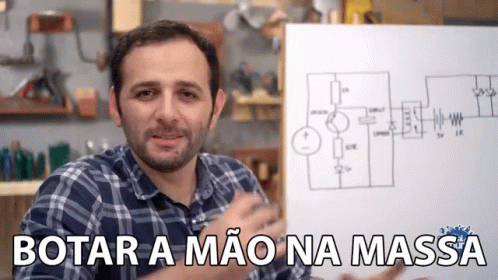


## Importando Bibliotecas
Importando bibliotecas que serão utilizadas durante a construção do projeto

In [141]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import string
import re
import nltk

import xgboost as xgb
import scipy.stats as st
from scipy.stats import randint as sp_randint
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Fazendo a Leitura da Base de Dados

In [142]:
# Fazendo a leitura do dataset
df_sarc = pd.read_csv('sarc_sample.csv')
df_sarc

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,Is patch 3.3 going to be our savior? Without t...
1,1,Yeah because Iran was 100% muslim prior to 197...,methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well a...
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND ...,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,Warriors / Clips game threads literally add ze...
3,1,"Yeah, it's dumb to run background checks on po...",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed wh..."
4,1,"Oh, it's not that bad once you get a handle on...",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.
...,...,...,...,...,...,...,...,...,...,...
59995,0,"room you mean like, dimension?",Tikikala,digimon,1,1,0,2016-03,2016-03-26 03:42:22,So as another guy pointed out. Huckmon might b...
59996,0,I wasn't too fond of grabner in 14 so I put Be...,mrhairybolo,hockey,1,1,0,2014-08,2014-08-10 05:57:31,Hall - Duchene - Grabner?
59997,0,he wasn't even at worlds in season 4!,Highstalker,leagueoflegends,-1,-1,0,2016-09,2016-09-19 14:41:23,Yeah he was.
59998,0,"Right, but the Trump sign...",gcbeehler5,pics,2,2,0,2016-09,2016-09-01 02:14:54,I wouldn't say you have to be liberal to appre...


## Iniciando Análise Exploratória 
Inicialmente é aplicado um '.describe()' para se ter informações sobre o dataframe no geral, como por exemplo, a quantidade de elementos e etc.

Após, utiliza-se o método '.info()' para ter informações sobre as colunas, como por exemplo, quais são seus tipos e se existem valores nulos.

Associado, a isso, apresenta-se a quantidade de elementos para cada classe do dataframe através do .'value_counts()' trazendo essa visualização se há desbalanceamento entre as classes. Essa análise de desbalanceamento será exposta logo mais através de um gráfico.


In [143]:
round(df_sarc.describe(),2)

,label,score,ups,downs
count,60000.00,60000.00,60000.00,60000.00
mean,0.67,6.85,5.58,-0.14
std,0.47,42.68,39.41,0.35
min,0.00,-143.00,-143.00,-1.00
25%,0.00,1.00,0.00,0.00
50%,1.00,2.00,1.00,0.00
75%,1.00,5.00,4.00,0.00
max,1.00,3325.00,3325.00,0.00


In [144]:
df_sarc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           60000 non-null  int64 
 1   comment         59999 non-null  object
 2   author          60000 non-null  object
 3   subreddit       60000 non-null  object
 4   score           60000 non-null  int64 
 5   ups             60000 non-null  int64 
 6   downs           60000 non-null  int64 
 7   date            60000 non-null  object
 8   created_utc     60000 non-null  object
 9   parent_comment  60000 non-null  object
dtypes: int64(4), object(6)
memory usage: 4.6+ MB


In [145]:
df_sarc['label'].value_counts()

1    40000
0    20000
Name: label, dtype: int64

### Exemplo da classe 0 (Sem Sarcasmo)
Continuando a análise, uma amostra dos textos dos comentários sem sarcasmos são apresentados de forma completa, abaixo:

In [146]:
nao_sarc = df_sarc.loc[df_sarc['label'] == 0]
#Utiliza-se o método set_option('max_colwidth', None) que possibilita a apresentação de todo os conteúdos das colunas do datraframe
pd.set_option('max_colwidth', None)
nao_sarc.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
40000,0,Then why fire the coach and hire Rich Rod if you guys were already good?,punkinale,CFB,11,11,0,2014-12,2014-12-02 21:00:31,I don't really think that's full circle. Michigan was good before Rich Rod took over
40001,0,"Whoa, easy there Duterte.",buckingbronco1,news,2,-1,-1,2016-12,2016-12-28 21:30:36,"He did. It's a smoking gun to me. I don't give a fucking shit what a court thinks, I don't play by their rules. When you get put in charge of watching over someone so drunk people are worried they're going to die, and you offered to do this, solely so you could be alone with them and then put your dick in them, to me, you're a fucking rapist. And that's what I think he did and that's why he apologized - because he knew he had something to apologize for. I don't care what the statue of Indiana says on rape, I don't care what the school says, I care about what I think rape is and this definitely qualifies. He's the type of loser that can't get pussy, and has to steal it from drunk girls after he manipulates himself into being alone with them."
40002,0,"The same reason Trudeau circlejerks, and Harper hate fests are allowed.",AngryMulcair,canada,3,3,0,2014-11,2014-11-14 23:10:39,Why are stupid and satire articles allowed on this subreddit?
40003,0,Good point but he'll still have to clean it to rack it for the front squat.,arabicfarmer27,Fitness,1,-1,-1,2016-11,2016-11-04 09:34:05,"But it would be a relatively light weight front-squat, he might want some additional squat work on top of that."
40004,0,Damn if I worked for valve my personal ban list would be so long full of kids like these.,MaxStavro,GlobalOffensive,72,72,0,2015-07,2015-07-10 06:39:02,Please don't be this guy.


### Exemplo da classe 1 (Com Sarcasmo)
Continuando a análise, uma amostra dos textos dos comentários com sarcasmos são apresentados de forma completa, abaixo:

In [147]:
sarc = df_sarc.loc[df_sarc['label'] == 1]
#Utiliza-se o método set_option('max_colwidth', None) que possibilita a apresentação de todo os conteúdos das colunas do datraframe
pd.set_option('max_colwidth', None)
sarc.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,"Is patch 3.3 going to be our savior? Without trying to sound like a broken record and repeating the many point of views of the growing apocalyptic threads on this forum. I was hoping to get the opinions of everyone if they believe patch 3.3 is going to bring back some of the players who have quit in the last patch or two, or does this feel like another cookie cutter patch that wont stop exit of quality population specifically on the North American servers. I ask this in concern that I have made a assertive effort as of late to refill our FC, and one of the strong points of the patch info so far is that they are installing a cross realm raid tool, which seems like it would diminish the need to recruit for a FC. I personally enjoy the aspect of a 10-15 member FC which can grow close and share things in common to the game and outside the game. But with the game seemingly losing subs it has become harder to find people to come together like I had just described and I don't want to put false hope in those who I have recruited so far. Give me some hope!"
1,1,"Yeah because Iran was 100% muslim prior to 1979, and still is now.",methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well as al-Qatb and the rise of Wahhabism. You are fully entitled to have an opinion and express it (and you do bring up a good point re: rural cobservatism) but you are misinformed.
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND POST AND TAKE YOUR DOWNVOTES,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,"Warriors / Clips game threads literally add zero value to the game experience. Why would I want to see the words flop, flopped and flopper repeated constantly? Thunder / Clips game threads were pretty good during the season. We'll see how the playoff ones are."
3,1,"Yeah, it's dumb to run background checks on potential teachers.",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed when you are hired! Awesome!"
4,1,"Oh, it's not that bad once you get a handle on the crippling depression and constant tooth grinding.",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.


Podemos analisar à partir dessa pequena amostra, que os comentários sarcásticos tendem a ser mais informais e com termos mais agressivos. Além disso, percebe-se que alguns comentários com sarcasmo são feitos através de caixa alta, demonstrando essa intensidade e informalidade nesse tipo de comentário. Já os não sarcásticos tendem a ser mais padrões, em caixa baixa. Em relação a tamanho de texto, podemos perceber que na verdade não tem diferença, nas duas classes há comentários mais longos e também mais curtos.

### Gráfico 1 -- Gráfico de Barras
Como já foi falado acima, neste gráfico de barras são apresentados as quantidades de elementos para cada uma das classes. 

Pode-se analisar, que o gráfico demonstra um desbalanceamento entre as classes, sendo que há 40000 linhas de comentários com sarcasmo (classe 1) e somente 20000 linhas de comentários sem sarcasmos (classe 0).

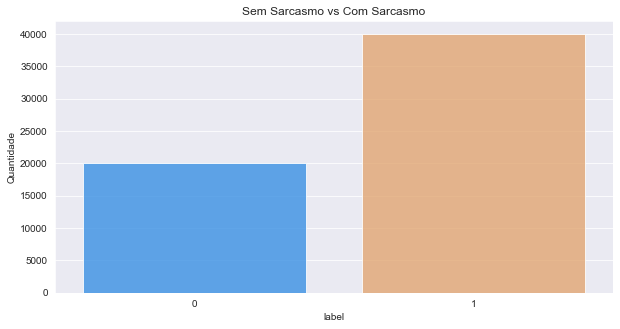

In [148]:
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df_sarc['label'], alpha =.80, palette= ['#1E90FF','#F4A460'])
plt.title('Sem Sarcasmo vs Com Sarcasmo')
plt.ylabel('Quantidade')
plt.show()

## Etapa de Limpeza e Pré-Processamento dos Dados
A etapa de pré-processamento dos dados se faz necessária para a continuidade da análise exploratória dos dados, isso pelo fato de a análise continuar com passos como o de apresentação de termos mais frequentes entre as classes. Logo, este pré-processamento é necessário.

Serão aplicadas algumas etapas de pré-processamento na coluna 'comment'(posteriormente também serão aplicadas na coluna 'parent_comment'), sendo essas:

    - Remoção de Pontuações(Função: remocao_pontuacao): Serão retiradas todas as pontuações dos textos dos comentários,sendo que esses, nesta situação, não trazem informações relevantes.
    - Letras minúsculas (Função: lowering): Retirando todas as palavras em minúscula para manter um padrão.
    - Stop Words (Função: remocao_stop_words): Stopwords são as palavras em qualquer idioma que não adicionam muito significado a uma frase. Eles podem ser ignorados com segurança sem sacrificar o significado da frase. Para alguns mecanismos de pesquisa, essas são algumas das palavras de função curtas mais comuns, como the, is, at, which e on, ou seja, podem ser retiradas
    - Remoção de Números (Função: remocao_numeros): Retirando todos os números que nesta situação, não trazem informações relevantes para a análise exploratória da coluna de comentários, sendo que o foco são as palavras dos textos.
    - Remoção de Pequenas Palavras (Função: remocao_peq_palavras): Retirando palavras com 2 ou menos caracteres pelo fato de normalmente serem erros de digitação e também por não trazerem informações importantes sobre o dataframe. 
    - Função 'preprocessamento': Na função final 'preprocessamento', são chamadas e aplicadas todas as etapas citadas acima.

##### Nova Coluna: 'clean_comment'
Após todas as estapas de pré-processamento, foi criada uma nova coluna com todos os comentários e seus textos pré-processados.

In [149]:
def remocao_pontuacao(texto):
    nao_pontuado = "".join([i for i in texto if i not in string.punctuation])
    return nao_pontuado

In [150]:
def lowering(texto):
    return texto.lower()

In [151]:
def remocao_numeros(texto):
    number_regex = '\d+'
    x = re.sub(number_regex, '', texto)
    return x

In [152]:
def remocao_stopwords(texto):
    stopwords = nltk.corpus.stopwords.words('english')
    texto_stopwords = [j for j in texto.split() if j not in stopwords]
    frase = " ".join(texto_stopwords)
    return frase 

In [153]:
def remocao_peq_palavras(texto):
    frase =" ".join([z for z in texto.split() if len(z) > 2])
    return frase

In [154]:
def preprocessamento(texto):
        texto = remocao_numeros(texto)
        texto = lowering(texto)
        texto = remocao_stopwords(texto)
        texto = remocao_pontuacao(texto)
        texto = remocao_peq_palavras(texto)
        return texto

# Esse método é para desabilitar a visualização total das colunas do dataset. 
pd.reset_option("display.max_colwidth")

df_sarc['comment'] = df_sarc['comment'].astype(str)
# Criei uma nova coluna após o pré-processamento 
df_sarc['clean_comment']= df_sarc['comment'].apply(lambda x: preprocessamento(x))
df_sarc

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,clean_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,Is patch 3.3 going to be our savior? Without t...,course like true messiah
1,1,Yeah because Iran was 100% muslim prior to 197...,methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well a...,yeah iran muslim prior still now
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND ...,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,Warriors / Clips game threads literally add ze...,well bitchyou post take downvotes
3,1,"Yeah, it's dumb to run background checks on po...",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed wh...",yeah dumb run background checks potential teac...
4,1,"Oh, it's not that bad once you get a handle on...",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.,bad get handle crippling depression constant t...
...,...,...,...,...,...,...,...,...,...,...,...
59995,0,"room you mean like, dimension?",Tikikala,digimon,1,1,0,2016-03,2016-03-26 03:42:22,So as another guy pointed out. Huckmon might b...,room mean like dimension
59996,0,I wasn't too fond of grabner in 14 so I put Be...,mrhairybolo,hockey,1,1,0,2014-08,2014-08-10 05:57:31,Hall - Duchene - Grabner?,fond grabner put bergeron middle win draws set...
59997,0,he wasn't even at worlds in season 4!,Highstalker,leagueoflegends,-1,-1,0,2016-09,2016-09-19 14:41:23,Yeah he was.,even worlds season
59998,0,"Right, but the Trump sign...",gcbeehler5,pics,2,2,0,2016-09,2016-09-01 02:14:54,I wouldn't say you have to be liberal to appre...,right trump sign


### Gráficos 2 e 3 - Gráficos de Barras
Apresentando os termos mais frequentes em cada classe. 

Isso só foi possível após o pré-processamento dos textos, para que por exemplo, pontuações, não fossem escolhidos como termos mais frequentes, por exemplo.

Inicialmente, fiz a divisão do dataframe para que eu pudesse ter através do 'sarc' somente os elementos da classe 1 e no 'não_sarc' somente os elementos da classe 0 para apresentar os gráficos de termos mais frequentes das duas classes.

In [155]:
# sarc para classe 1 e nao_sarc para a classe 0
sarc = df_sarc.loc[df_sarc['label'] == 1]
nao_sarc = df_sarc.loc[df_sarc['label'] == 0]

### Gráfico de Termos Mais Frequentes da Classe 0 (Sem Sarcasmo)
Abaixo está o gráfico com os termos mais frequentes dos textos que não são considerados sarcasmos. Podemos analisar que o 'like' que no inglês pode ter vários contextos em várias situações (isso pode ser uma das explicações de ser o termo mais frequente), é o termo mais frequente. Da mesma forma é o 'would' que no caso, é o segundo termo mais usado.

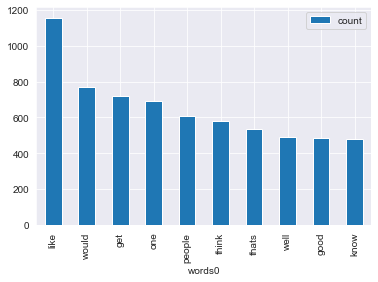

In [156]:
words0 = []

#Pegando termo por termo -- classe 0
for i in nao_sarc['clean_comment']:
    for j in i.split():
        words0.append(j)
        
dfp0 = pd.DataFrame (words0, columns = ['words0'])
dfc = dfp0.groupby('words0').words0.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(10).reset_index(drop=True)

dfc.plot.bar(x='words0');

### Gráfico de Termos Mais Frequentes da Classe 1 (Com Sarcasmo)
Abaixo está o gráfico com os termos mais frequentes dos textos que são considerados sarcasmos, podemos perceber que o 'yeah' que no inglês é uma variação do 'yes', ou seja, que no português é sim, é o termo mais frequente. 

O interessante é perceber que este termo só tem grande denotação nos comentários sarcásticos. Em segundo está o 'like' que como na classe 0, é bastante utilizado por nativos do inglês em várias situações e com mais de um significado.

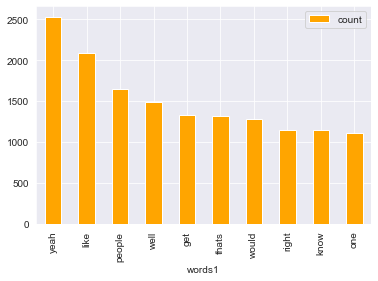

In [157]:
words1 = []

#Pegando termo por termo -- classe 1
for i in sarc['clean_comment']:
    for j in i.split():
        words1.append(j)

dfp1 = pd.DataFrame(words1, columns = ['words1'])
dfc = dfp1.groupby('words1').words1.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(10).reset_index(drop=True)

dfc.plot.bar(x='words1', color='orange');

### Gráfico 4 e 5 -- Distribuição (Histograma e Kernel Density Estimation (KDE))
### Finalizando a Análise Exploratória 

Histograma: Foi produzido um histograma para ver a quantidade de caracteres de uma forma distribúida empiricamente e discretizada.

Kernel Density Estimation (KDE): Foi produzido um histograma para ver a quantidade de caracteres de uma forma distribúida continuamente, mostrando as curvas, como por exemplo, demonstrando que a classe 0 possui uma cauda longa, sendo que esses são poucos comentários mas com uma grande quantidade de caracteres.

#### Histograma de Caracteres

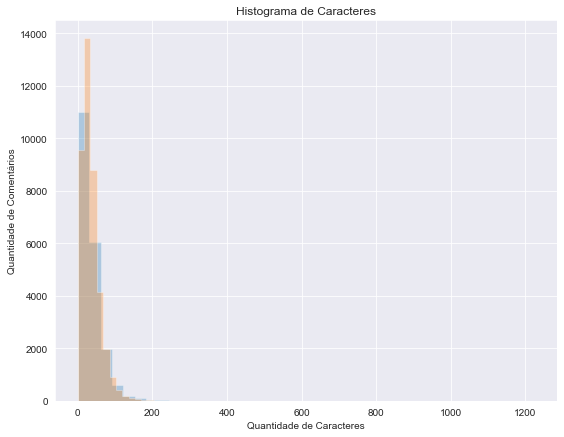

In [158]:
df_sarc['tamanho_texto'] = df_sarc['clean_comment'].apply(len)

x0 = list(df_sarc[df_sarc['label']==0]['tamanho_texto'])
x1 = list(df_sarc[df_sarc['label']==1]['tamanho_texto'])

kwargs = dict(histtype='stepfilled',alpha=0.3, bins=40)
plt.figure(figsize=(9,7))
plt.hist(x0, **kwargs);
plt.hist(x1, **kwargs);
plt.xlabel('Quantidade de Caracteres');
plt.ylabel('Quantidade de Comentários');
plt.title('Histograma de Caracteres');

#### Kernel Density Estimation (KDE)

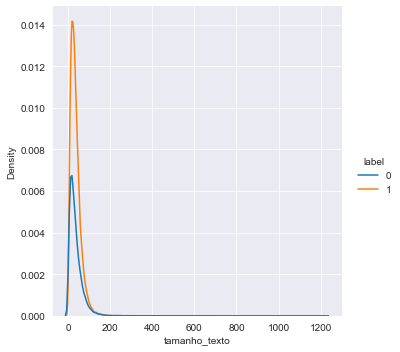

In [159]:
sns.displot(df_sarc, x="tamanho_texto", hue="label", kind="kde");

As distribuições demonstram que as duas classes em sua maioria tem como características comentários não tão longos, talvez seja um padrão da própria rede social de onde derivou a base. Isso podemos ver nos dois tipos de distribuições apresentadas. 

Associado a isso, destaca-se no kde a cauda longa que denota a presença de comentários mais longos na classe 0, demonstrando que provavelmente sejam textos que estão querendo passar uma ideia ou uma explicação, sendo naturalmente algo mais elaborado.

## Etapa de Limpeza e Pré-Processamento dos Dados -- Continuidade
Aqui dará continuidade, o pré-processamento da coluna 'comment' e pré-processarei também a coluna 'parent_comment' para utilização futura, criando uma nova coluna pré-processada 'clean_parent_comment'.

A continuação do pré-processamento ocorre após a análise exploratória pelo fato da continuidade ser importante para o resto do projeto e não para a etapa de análise exploratória. 

Associado a isso, acrescentei mais uma etapa de pré-porocesamento.

Serão aplicadas uma etapa de pré-processamento na coluna 'comment'(lematização) e todas as etapas na coluna 'parent_comment', incluindo a lemmatização através do segundo pré-processamento, sendo essas:

    - Lematização (Função: 'lemmatizacao'): Ela deriva a palavra, mas garante que ela não perca seu significado. A lematização possui um dicionário pré-definido que armazena o contexto das palavras e verifica a palavra no dicionário enquanto diminui.
    - Função 'preprocessamento2': É chamada e aplicada todas as etapas de preprocessamento e tendo como acréscimo a chamada e aplicação da etapa de lematização.

In [160]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizacao(texto):
    lemm_texto = [wordnet_lemmatizer.lemmatize(word) for word in texto.split()]
    frase = " ".join(lemm_texto)
    return frase

In [161]:
# Fiz essa função preprocessamento2 porque estou trabalhando em mais uma etapa de pré-processamento além da lematização
#Estou pensando em outra, lucas
def preprocessamento2(texto):
        texto = preprocessamento(texto)
        texto = lemmatizacao(texto)
        return texto

df_sarc['clean_comment']= df_sarc['clean_comment'].apply(lambda x: lemmatizacao(x))
df_sarc['clean_parent_comment']= df_sarc['parent_comment'].apply(lambda x: preprocessamento2(x))

## Engenharia de Atributos
## Conjunto de Atributos Baseline: 

No conjunto de atributos 1, o atributo de entrada será somente a coluna 'comment' (sendo nela a coluna onde está contido os comentários sarcásticos e não-sarcásticos) já pré-processada como 'clean_comment'. Minha saída serão as classes 0 (Sem Sarcasmo) e classe 1 (Com Sarcasmo).

O método para representação vetorial escolhido foi o Bag of Words (Saco de Palavras). Abaixo trarei uma definição e características deste método de vetorização.

## Bag of Words
Saco de palavras é uma técnica de processamento de linguagem natural de modelagem de texto. Em termos técnicos, podemos dizer que é um método de extração de recursos com dados de texto. Essa abordagem é uma maneira simples e flexível de extrair recursos de documentos.

Um saco de palavras é uma representação de texto que descreve a ocorrência de palavras dentro de um documento. Nós apenas acompanhamos a contagem de palavras e desconsideramos os detalhes gramaticais e a ordem das palavras. É chamado de “saco” de palavras porque qualquer informação sobre a ordem ou estrutura das palavras no documento é descartada. O modelo se preocupa apenas com a ocorrência de palavras conhecidas no documento, e não com a localização do documento.

## Estabelecimento de Um Baseline
O Baseline será utilizando o conjunto de atributos 1.
### Modelo Escolhido para o Baseline: Multinomial Naive Bayes
De forma resumida, o algoritmo Naive Bayes funciona como classificador e baseia-se na probabilidade de cada evento ocorrer, desconsiderando a correlação entre features. Por ter uma parte matemática relativamente simples, possui um bom desempenho e precisa de poucas observações para ter uma boa acurácia. Logo, o multinomial implementa o algoritmo Naive Bayes para dados multinomialmente distribuídos e é uma das duas variantes clássicas Naive Bayes usadas na classificação de texto (onde os dados são tipicamente representados como contagens de vetores de palavras, embora os vetores tf-idf também sejam conhecidos por funcionar bem na prática).

O modelo Naive Bayes foi escolhido para ser o baseline por ser muito simples e rápido, possui um desempenho relativamente maior do que outros classificadores. Além disso, o Naive Bayes só precisa de um pequeno número de dados de teste para concluir classificações com uma boa precisão.

Logo, defini as entradas e depois fiz a divisão e treino através do método 'train_test_split'. Defini para treino 80% e para teste 20% e além disso, apliquei o método 'stratify', como o nome já diz, faz uma divisão de forma que a proporção dos valores na amostra produzida seja a mesma que a proporção dos valores fornecidos ao parâmetro stratify, ou seja, deixar a proporção mais justa quando for fazer as predições dos modelos com os dados de teste.

In [162]:
X = df_sarc[['clean_comment']]
y = df_sarc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Método de Vetorização 

Ressalta-se que os textos de entrada dos treinos e testes já foram pré-processadas anteriormente, como foi exposto.

Na minha aplicação de vetorização, será definido previamente na mesma, os limites inferiores e superiores do intervalo de valores n para diferentes n-grams de palavras ou char n-grams a serem extraídos, ou seja, foi definido o 'ngram_range' = (1, 2), que significa que a vetorização irá extrair previamente unigramas e bigramas na vetorização. Além disso, através do parâmetro "min_df" igual a 2, ignoro as palavras que aparecem em menos de dois documentos.

No sklearn pode ser utilizado através do método 'CountVectorizer'.

In [163]:
bagwords = CountVectorizer(ngram_range=(1,2), min_df=2)

In [164]:
X_train_bag = bagwords.fit_transform(X_train['clean_comment'])
X_test_bag = bagwords.transform(X_test['clean_comment'])

##### Após aplicação de método de vetorização no treino e teste, continuamos a construção do baseline.

In [165]:
model = MultinomialNB()
model.fit(X_train_bag, y_train)

MultinomialNB()

## Métrica de Resultado para Todos os Modelos
F1-Score: Essa métrica combina precisão e recall de modo a trazer um número único que indique a qualidade geral do seu modelo e trabalha bem até com conjuntos de dados que possuem classes desproporcionais, sendo esse um dos principais motivos de ter escolhido essa métrica.

A média que iremos calcular é a média harmônica, quando os dois valores do cálculo são iguais. Essa média gera resultados muito próximos da média “comum”.

A fórmula que define o F1 é a seguinte (quanto maior melhor o modelo):
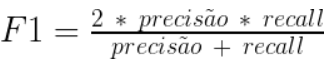

No sklearn utilizamos a métrica através do 'f1_score'.

Ressalta-se que modificarei o parâmetro average da métrica, que possui como o default 'binary', para o 'macro'. A escolha do macro é pelo fato de se calcular as métricas para cada classe e encontre sua média não ponderada. O que mais me pesou na escolha foi o fato de através do macro, o mesmo não levar em consideração o desbalanceio das classes.  

In [166]:
y_pred = model.predict(X_test_bag)
f1_score_baseline = round(f1_score(y_test,y_pred,average='macro')*100,2)
print('========= F1-SCORE BASELINE ===========')
print('O F1-SCORE do Baseline, foi:' ,f1_score_baseline)

========= F1-SCORE BASELINE ===========
O F1-SCORE do Baseline, foi: 58.68


## Engenharia de Atributos
## Conjunto de Atributos 1
## Seleção e Avaliação de Modelos 
No meu Conjunto 1, utilizo as mesmas características do baseline, por isso, irei dividir em treino e validação já com o X pré-processado e vetorizado. A única diferença é que os modelos serão balanceados, ou seja, será feito um balanceamento para deixar as classes mais igualitárias. 

## Modelo 1 - Regressão Logística
De forma resumida, a Regressão Logística é um algoritmo de aprendizagem de máquina supervisionado utilizado para classificação, apesar de ter a palavra regressão em seu nome. Essa nomenclatura está relacionada com o fato da Regressão Logística ser construída a partir da aplicação de uma transformação/função (denominada função logística ou sigmoide) sobre a Regressão Linear.

O modelo de regressão logística foi escolhido por permitir: modelar a probabilidade de um evento ocorrer dependendo dos valores das variáveis independentes, que podem ser categóricas ou contínuas.

In [167]:
model1 = LogisticRegression()
model1.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

## Balanceamento dos dados
O balanceamento dos dados ocorreu através da utilização da biblioteca 'imbalanced learn', em que através da utilização do método 'RandomOverSample' objetiva o balanceamento de classes, fazendo uma maximização da classe que possue menos elementos, sendo que essa maximização é feita através da criação desses novos elementos para a classe desbalanceada. 

Isso faz com que ao construir um modelo de aprendizado com o dataframe, o modelo não seja influenciado pela classe com maior quantidade de dados. 

O meu objetivo é ao obter todos os resultados, utilizar o modelo balanceado com melhor resultado e fazer a análise de seus resultados desbalanceados.

In [168]:
balance = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = balance.fit_resample(X_train, y_train)

### Vetorizando Novamente Após Balanceamento

In [169]:
X_train_bag = bagwords.fit_transform(X_train_bal['clean_comment'])
X_test_bag = bagwords.transform(X_test['clean_comment'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo de Regressão
### Otimização --- RandomSearch CV

A otimização feita no modelo de Regressão Logística foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - C: Inverso da força de regularização, quanto menor o seu valor, maior a força de regularização.
    - Penalty: Tecnica de regularização que será utilizada.
    - Solver: Algoritmo que será utilizado para o problema da otimização.
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [170]:
warnings.filterwarnings("ignore")
# Definindo os parâmetros que serão utilizados no RandomSearchCV
#C: Inverso da força de regularização; devendo ser um float positivo. Como em SVM, valores menores especificam uma regularização mais forte.
model1_params = dict(
    C= [0.001, 0.01, 0.1, 1],
    penalty= ['l1', 'l2', 'elasticnet'],
    max_iter= [300, 600],
    solver = ['newton-cg', 'liblinear', 'sag', 'saga'],
    tol= [0.01,0.001,0.0001]
)
meu_primeiro_random = RandomizedSearchCV(model1,model1_params,random_state=42)

meu_primeiro_random.fit(X_train_bag,y_train_bal.ravel())

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1],
                                        'max_iter': [300, 600],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'liblinear',
                                                   'sag', 'saga'],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42)

In [171]:
meu_primeiro_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

LogisticRegression(C=0.1, max_iter=300, solver='newton-cg', tol=0.001)

##### Após aplicação do método de otimização de hiperparâmetros, continuamos com a construção do modelo otimizado.

In [172]:
y_pred1 = meu_primeiro_random.predict(X_test_bag)
f1_score_1 = round(f1_score(y_test,y_pred1,average='macro')*100,2)
print('========= F1-SCORE REGRESSÃO LOGÍSTICA ===========')
print('O F1-SCORE do Modelo Regressão Logística Otimizado, do Conjunto 1, foi:' ,f1_score_1)

========= F1-SCORE REGRESSÃO LOGÍSTICA ===========
O F1-SCORE do Modelo Regressão Logística Otimizado, do Conjunto 1, foi: 64.0


## Modelo 2  - Multinomial Naive Bayes Otimizado
De forma resumida, o algoritmo Naive Bayes funciona como classificador e baseia-se na probabilidade de cada evento ocorrer, desconsiderando a correlação entre features. Por ter uma parte matemática relativamente simples, possui um bom desempenho e precisa de poucas observações para ter uma boa acurácia. 

Logo, o multinomial implementa o algoritmo Naive Bayes para dados multinomialmente distribuídos e é uma das duas variantes clássicas Naive Bayes usadas na classificação de texto (onde os dados são tipicamente representados como contagens de vetores de palavras, embora os vetores tf-idf também sejam conhecidos por funcionar bem na prática).

Foi escolhido para se analisar seu resultado também após a tentativa de otimização dos seus parâmetros.

In [173]:
model2 = MultinomialNB()
model2.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo Naive Bayes
### Otimização --- GridSearch CV
A otimização feita no modelo Naive Bayes foi utilizando o Grid Search. A pesquisa de grade pode ser pensada como uma pesquisa exaustiva para selecionar um modelo. Na pesquisa de grade, o cientista de dados configura uma grade de valores de hiperparâmetros e, para cada combinação, treina um modelo e pontua nos dados de teste. Nesta abordagem, todas as combinações de valores de hiperparâmetros são tentadas, o que pode ser muito ineficiente, pela questão do tempo e custo computacional. O Scikit Learn oferece a função 'GridSearchCV' para esse processo. 

Ressalta-se que através do 'GridSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - Alpha: É o "Smoothing parameter" utilizado na equação "Laplace Smoothing" para resolver o problema da probabilidade zero no algoritmo Naive Bayes
    - Fit_prior: Define se o algoritmo deve aprender a "Prior probability"(probabilidade de um evento ocorrer antes de novos dados serem coletados) dos dados.

In [174]:
warnings.filterwarnings("ignore")
model2_params = {'alpha':[0.5,1.0,1.5, 2.0,2.5,3],
                 'fit_prior': [True, False]}

meu_primeiro_grid = GridSearchCV(model2,model2_params)

meu_primeiro_grid.fit(X_train_bag,y_train_bal.ravel())

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3],
                         'fit_prior': [True, False]})

In [175]:
meu_primeiro_grid.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do GridSearch, foram esses:

MultinomialNB(alpha=0.5)

##### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [176]:
y_pred2 = meu_primeiro_grid.predict(X_test_bag)
f1_score_2 = round(f1_score(y_test,y_pred2,average='macro')*100,2)
print('========= F1-SCORE NAIVE BAYES OTIMIZADO ===========')
print('O F1-SCORE do Modelo Naive Bayes Otimizado, do Conjunto 1, foi:' ,f1_score_2)

========= F1-SCORE NAIVE BAYES OTIMIZADO ===========
O F1-SCORE do Modelo Naive Bayes Otimizado, do Conjunto 1, foi: 57.28


## Modelo 3 - Stochastic Gradient Descendent Classifier (SGDClassifier)
SGDClassifier é de fato uma técnica que é usada para encontrar os mínimos de uma função. SGDClassifier é um classificador (por padrão no sklearn é um SVM) que usa SGD para treinamento (ou seja, procurando os mínimos da perda usando SGD). De acordo com a documentação:

Este estimador implementa modelos lineares regularizados com aprendizado estocástico de gradiente descendente (SGD): o gradiente da perda é estimado em cada amostra de cada vez e o modelo é atualizado ao longo do caminho com um cronograma de força decrescente (também conhecido como taxa de aprendizado). Para obter melhores resultados usando a programação de taxa de aprendizado padrão, os dados devem ter média zero e variância unitária.

Essa implementação funciona com dados representados como matrizes densas ou esparsas de valores de ponto flutuante para os recursos. O modelo que ele se ajusta pode ser controlado com o parâmetro de perda; por padrão, ele se encaixa em uma máquina de vetor de suporte linear (SVM).

Foi escolhido pelo fato de ser um classificador (por padrão no sklearn é um SVM) que usa SGD para treinamento (ou seja, procurando os mínimos da perda usando SGD).

In [177]:
model3 = SGDClassifier()
model3.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo SGDClassifier
### Otimização --- RandomSearch CV
A otimização feita no modelo SGDClassifier foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - Alpha: Constante que multiplica o prazo de regularização. Quanto maior o valor, mais forte a regularização. Também usado para calcular a taxa de aprendizado quando definido como learning_rate é definido como 'ótimo'.
    - Penalty: Tecnica de regularização que será utilizada. 
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [178]:
model3_params = {
              'tol': [0.01,0.001,0.0001],
              'max_iter': [100,300,600],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ["none", "l1", "l2"]}

meu_segundo_random = RandomizedSearchCV(model3,model3_params,cv=5)

meu_segundo_random.fit(X_train_bag,y_train_bal.ravel())

RandomizedSearchCV(cv=5, estimator=SGDClassifier(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'max_iter': [100, 300, 600],
                                        'penalty': ['none', 'l1', 'l2'],
                                        'tol': [0.01, 0.001, 0.0001]})

In [179]:
meu_segundo_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

SGDClassifier(max_iter=300, penalty='none', tol=0.01)

#### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [180]:
y_pred3 = meu_segundo_random.predict(X_test_bag)
f1_score_3 = round(f1_score(y_test,y_pred3,average='macro')*100,2)
print('========= F1-SCORE SGDCLASSIFIER OTIMIZADO ===========')
print('O F1-SCORE do SGDClassifier Otimizado, do Conjunto 1, foi:' ,f1_score_3)

========= F1-SCORE SGDCLASSIFIER OTIMIZADO ===========
O F1-SCORE do SGDClassifier Otimizado, do Conjunto 1, foi: 61.13


## Modelo 4 - XGBoosting (Modelo Novo)
O XGBoost significa eXtreme Gradient Boosting, que é um algoritmo de aumento baseado no algoritmo de árvores de decisão com aumento de gradiente. O XGBoost aplica uma técnica de regularização melhor para reduzir o overfitting, e é uma das diferenças do aumento de gradiente. O 'xgboost' é uma biblioteca de código aberto que fornece algoritmos de aprendizado de máquina sob os métodos de aumento de gradiente.

Já o xgboost.XGBClassifier é uma classe compatível com a API scikit-learn para classificação.

Outra definição: 'Pense no XGBoost como um aumento de gradiente em 'esteróides' (bem, é chamado de 'Extremo Gradient Boosting' por um motivo!). É uma combinação perfeita de técnicas de otimização de software e hardware para produzir resultados superiores usando menos recursos de computação no menor tempo possível.'

Foi escolhido pelo fato de ser um método que está sendo bastante utilizado e além disso, gostaria de ver como seria o comportamento e o resultado  de uma algoritmo baseado em árvores.

In [181]:
model4 = xgb.XGBClassifier()
model4.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo XGBoosting
### Otimização --- RandomSearch CV
A otimização feita no modelo XGBoosting foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 

    - n_estimators: especifica o número de árvores de decisão a serem impulsionadas. Se n_estimator = 1, significa que apenas 1 árvore é gerada, portanto, nenhum aumento está funcionando.
    - max_depth: Indica a altura máxima das árvores usadas pelo modelo, ou seja: a quantidade máxima de Nodes que podem haver da raiz até uma folha. Quanto maior, mais complexo será o modelo, portanto deve haver um equilíbrio para evitar tanto um overfitting (complexo demais) quanto underfitting (simples demais).
    - learning_rate: é um parâmetro de regularização que reduz os pesos dos recursos em cada etapa de reforço.
    - colsample_bytree: é a razão de subamostra de colunas ao construir cada árvore. A subamostragem ocorre uma vez para cada árvore construída.
    - gamma: é outro parâmetro de regularização para poda de árvores. Especifica a redução mínima de perda necessária para cultivar uma árvore.
    - scale_pos_weight: Este parâmetro é útil caso você tenha um conjunto de dados desequilibrado, principalmente em problemas de classificação, onde a proporção de uma classe é uma pequena fração do total de observações (por exemplo, fraude de cartão de crédito)
    - min_child_weight: O peso mínimo, ou quantidade mínima de amostras se todas tiverem peso 1, necessário para cada árvore criar um novo Node. Um valor pequeno vai permitir o algoritmo criar Nodes que correspondem a uma quantidade menor de amostras, fazendo assim o modelo ficar mais complexo.

In [182]:
warnings.filterwarnings("ignore")
model4_params = {
            "n_estimators": st.randint(3, 40),
            "max_depth": st.randint(3, 40),
            "learning_rate": st.uniform(0.05, 0.4),
            "colsample_bytree": st.beta(10, 1),
            "subsample": st.beta(10, 1),
            "gamma": st.uniform(0, 10),
            'scale_pos_weight': st.randint(0, 2),
            "min_child_weight": st.expon(0, 50)
}
              

meu_terceiro_random = RandomizedSearchCV(model4,model4_params,random_state=42)

meu_terceiro_random.fit(X_train_bag,y_train_bal.ravel(),eval_metric='logloss')

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023E2A569C40>,
                                        'n_estimators': <scipy.st

In [183]:
meu_terceiro_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9805992516764205,
              enable_categorical=False, gamma=9.695846277645586, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.36005312934444583, max_delta_step=0, max_depth=36,
              min_child_weight=25.138758787936954, missing=nan,
              monotone_constraints='()', n_estimators=38, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9233799272854253, tree_method='exact',
              validate_parameters=1, verbosity=None)

##### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [184]:
y_pred4 = meu_terceiro_random.predict(X_test_bag)
f1_score_4 = round(f1_score(y_test,y_pred4,average='macro')*100,2)
print('========= F1-SCORE XGBOOSTING OTIMIZADO ===========')
print('O F1-SCORE Modelo XGBoosting Otimizado, do Conjunto 1, foi:' ,f1_score_4)

========= F1-SCORE XGBOOSTING OTIMIZADO ===========
O F1-SCORE Modelo XGBoosting Otimizado, do Conjunto 1, foi: 58.05


### Melhor Modelo Desbalanceado do Conjunto 1
O modelo balanceado com melhor resultado no Conjunto 1 foi a Regressão Logística.  Logo, para motivos de teste e apresentação, irei fazer meu melhor modelo do Conjunto 1 de forma desbalanceada para podermos comparar os resultados na tabela de resultado geral.

## Modelo 5 - Melhor Modelo Desbalanceado

In [185]:
model5 = LogisticRegression()
model5.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [186]:
X_train_bag = bagwords.fit_transform(X_train['clean_comment'])
X_test_bag = bagwords.transform(X_test['clean_comment'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo de Regressão
### Otimização --- RandomSearch CV

A otimização feita no modelo de Regressão Logística foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - C: Inverso da força de regularização, quanto menor o seu valor, maior a força de regularização.
    - Penalty: Tecnica de regularização que será utilizada.
    - Solver: Algoritmo que será utilizado para o problema da otimização.
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [187]:
warnings.filterwarnings("ignore")
# Definindo os parâmetros que serão utilizados no RandomSearchCV
#C: Inverso da força de regularização; devendo ser um float positivo. Como em SVM, valores menores especificam uma regularização mais forte.
model5_params = dict(
    C= [0.001, 0.01, 0.1, 1],
    penalty= ['l1', 'l2', 'elasticnet'],
    max_iter= [300, 600],
    solver = ['newton-cg', 'liblinear', 'sag', 'saga'],
    tol= [0.01,0.001,0.0001]
)
melhor_conj1_random = RandomizedSearchCV(model5,model5_params,random_state=42)

melhor_conj1_random.fit(X_train_bag,y_train.ravel())

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1],
                                        'max_iter': [300, 600],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'liblinear',
                                                   'sag', 'saga'],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42)

In [188]:
meu_primeiro_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

LogisticRegression(C=0.1, max_iter=300, solver='newton-cg', tol=0.001)

#### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [189]:
y_pred5 = melhor_conj1_random.predict(X_test_bag)
f1_score_5 = round(f1_score(y_test,y_pred5,average='macro')*100,2)
print('========= F1-SCORE REGRESSÃO LOGÍSTICA DESBALANCEADA ===========')
print('O F1-SCORE da Regressão Logística Otimizada e Desbalanceada, do Conjunto 1, foi:' ,f1_score_5)

========= F1-SCORE REGRESSÃO LOGÍSTICA DESBALANCEADA ===========
O F1-SCORE da Regressão Logística Otimizada e Desbalanceada, do Conjunto 1, foi: 53.65


## Engenharia de Atributos
## Conjunto de Atributos 2
## Seleção e Avaliação de Modelos
No conjunto de atributos 2, que será usado para a construção de mais 4 modelos, o atributo de entrada serão as colunas 'clean_comment' e 'clean_parent_comment'. Essas colunas são respectivamente, a coluna 'comment' e 'parent_comment' com todo o pré-processamento que acima foi: construído, explicado e aplicado nas duas colunas, ou seja, as colunas de entrada já estão pré-processadas. 

Minha saída serão as classes 0 (Sem Sarcasmo) e classe 1 (Com Sarcasmo). Porquê a escolha demudar as entradas de atributos? Isso ocorre pelo fato de que a coluna 'parent_comment' ser o o comentário master, ou seja, foi desse comentário que derivou a coluna 'comment' em que está apresentado os comentários que definem se é um comentário sarcástico ou não. Logo, por essa correlação entre as duas colunas e a saída, é que compus o conjunto 2 desta maneira. Para isso, na entrada de dados, irei fazer a concatenação das duas colunas em uma nova coluna chamada "concat" para facilitar a vetorização dos dados.

In [190]:
X = df_sarc[['clean_comment', 'clean_parent_comment']]
y = df_sarc['label']

In [191]:
# Ressalta-se que o .agg é um método de agregação do próprio pandas que consequentemente, opera com dataframes e suas colunas. 
X['concat'] = X[['clean_comment', 'clean_parent_comment']].agg(' '.join, axis=1)
X

,clean_comment,clean_parent_comment,concat
0,course like true messiah,patch going savior without trying sound like b...,course like true messiah patch going savior wi...
1,yeah iran muslim prior still now,suggest research iran pre well alqatb rise wah...,yeah iran muslim prior still now suggest resea...
2,well bitchyou post take downvotes,warrior clip game thread literally add zero va...,well bitchyou post take downvotes warrior clip...
3,yeah dumb run background check potential teacher,forgot get finger printed hired awesome,yeah dumb run background check potential teach...
4,bad get handle crippling depression constant t...,haha definitely option than,bad get handle crippling depression constant t...
...,...,...,...
59995,room mean like dimension,another guy pointed out huckmon might projecti...,room mean like dimension another guy pointed o...
59996,fond grabner put bergeron middle win draw set ...,hall duchene grabner,fond grabner put bergeron middle win draw set ...
59997,even world season,yeah wa,even world season yeah wa
59998,right trump sign,say liberal appreciate sustainability ignorant...,right trump sign say liberal appreciate sustai...


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Balaceamento dos dados 
O balanceamento dos dados ocorreu através da utilização da biblioteca 'imbalanced learn', em que através da utilização do método 'RandomOverSample' objetiva o balanceamento de classes, fazendo uma maximização da classe que possue menos elementos, sendo que essa maximização é feita através da criação desses novos elementos para a classe desbalanceada.

Isso faz com que ao construir um modelo de aprendizado com o dataframe, o modelo não seja influenciado pela classe com maior quantidade de dados.

O meu objetivo é ao obter todos os resultados, utilizar o modelo balanceado com melhor resultado e fazer a análise de seus resultados desbalanceados.

In [193]:
balance = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = balance.fit_resample(X_train, y_train)



Associado a isso, método para representação vetorial escolhido para o Conjunto de Atributos 2, foi o TF-IDF.

## TF-IDF

TF-IDF ('term frequency'-'inverse document frequency') é uma medida estatística que avalia a relevância de uma palavra para um documento em uma coleção de documentos.

Isso é feito multiplicando duas métricas: quantas vezes uma palavra aparece em um documento e a frequência inversa do documento da palavra em um conjunto de documentos.

Ele tem muitos usos, principalmente na análise automatizada de texto, e é muito útil para pontuar palavras em algoritmos de aprendizado de máquina para processamento de linguagem natural (NLP).

O TF-IDF foi inventado para busca de documentos e recuperação de informações. Ele funciona aumentando proporcionalmente ao número de vezes que uma palavra aparece em um documento, mas é compensado pelo número de documentos que contêm a palavra. Portanto, palavras comuns em todos os documentos, como este, o que e se, têm uma classificação baixa, embora possam aparecer muitas vezes, pois não significam muito para esse documento em particular.


## Método de Vetorização -- Conjunto de Atributos 2
No sklearn pode ser utilizado através do método 'TfidfVectorizer'.

Ressalta-se que os textos de entrada dos treinos e testes já foram pré-processadas que eu construí anteriormente, como foi exposto. 

Na minha aplicação de vetorização, será definido previamente na mesma, os limites inferiores e superiores do intervalo de valores n para diferentes n-grams de palavras ou char n-grams a serem extraídos, ou seja, foi definido o 'ngram_range' = (1, 2), que significa que a vetorização irá extrair previamente unigramas e bigramas na vetorização. Além disso, através do parâmetro "min_df" igual a 2 ignoro as palavras que aparecem em menos de dois documentos.


In [194]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)

In [195]:
X_train_tfidf = tfidf.fit_transform(X_train_bal['concat'])
X_test_tfidf = tfidf.transform(X_test['concat'])

## Modelo 1  - Multinomial Naive Bayes Otimizado
De forma resumida, o algoritmo Naive Bayes funciona como classificador e baseia-se na probabilidade de cada evento ocorrer, desconsiderando a correlação entre features. Por ter uma parte matemática relativamente simples, possui um bom desempenho e precisa de poucas observações para ter uma boa acurácia. 

Logo, o multinomial implementa o algoritmo Naive Bayes para dados multinomialmente distribuídos e é uma das duas variantes clássicas Naive Bayes usadas na classificação de texto (onde os dados são tipicamente representados como contagens de vetores de palavras, embora os vetores tf-idf também sejam conhecidos por funcionar bem na prática).


In [196]:
model1_2 = MultinomialNB()
model1_2.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo Naive Bayes
### Otimização --- GridSearch CV
A otimização feita no modelo Naive Bayes foi utilizando o Grid Search. A pesquisa de grade pode ser pensada como uma pesquisa exaustiva para selecionar um modelo. Na pesquisa de grade, o cientista de dados configura uma grade de valores de hiperparâmetros e, para cada combinação, treina um modelo e pontua nos dados de teste. Nesta abordagem, todas as combinações de valores de hiperparâmetros são tentadas, o que pode ser muito ineficiente, pela questão do tempo e custo computacional. O Scikit Learn oferece a função 'GridSearchCV' para esse processo. 

Ressalta-se que através do 'GridSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - Alpha: É o "Smoothing parameter" utilizado na equação "Laplace Smoothing" para resolver o problema da probabilidade zero no algoritmo Naive Bayes
    - Fit_prior: Define se o algoritmo deve aprender a "Prior probability"(probabilidade de um evento ocorrer antes de novos dados serem coletados) dos dados.

In [197]:
warnings.filterwarnings("ignore")
model1_2_params = {'alpha':[0.5,1.0,1.5, 2.0,2.5,3],
                 'fit_prior': [True, False]}

meu_segundo_grid = GridSearchCV(model1_2,model1_2_params)

meu_segundo_grid.fit(X_train_tfidf,y_train_bal.ravel())

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3],
                         'fit_prior': [True, False]})

In [198]:
meu_segundo_grid.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do GridSearch, foram esses:

MultinomialNB(alpha=0.5)

##### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [199]:
pred_y1 = meu_segundo_grid.predict(X_test_tfidf)
f1_score_2_1 = round(f1_score(y_test,pred_y1,average='macro')*100,2)
print('========= F1-SCORE NAIVE BAYES OTIMIZADO ===========')
print('O F1-SCORE do Modelo Naive Bayes Otimizado, do Conjunto 2, foi:' ,f1_score_2_1)

========= F1-SCORE NAIVE BAYES OTIMIZADO ===========
O F1-SCORE do Modelo Naive Bayes Otimizado, do Conjunto 2, foi: 45.75


## Modelo 2 -- SGDClassifier
SGDClassifier é de fato uma técnica que é usada para encontrar os mínimos de uma função. SGDClassifier é um classificador (por padrão no sklearn é um SVM) que usa SGD para treinamento (ou seja, procurando os mínimos da perda usando SGD). De acordo com a documentação:

Este estimador implementa modelos lineares regularizados com aprendizado estocástico de gradiente descendente (SGD): o gradiente da perda é estimado em cada amostra de cada vez e o modelo é atualizado ao longo do caminho com um cronograma de força decrescente (também conhecido como taxa de aprendizado). Para obter melhores resultados usando a programação de taxa de aprendizado padrão, os dados devem ter média zero e variância unitária.

Essa implementação funciona com dados representados como matrizes densas ou esparsas de valores de ponto flutuante para os recursos. O modelo que ele se ajusta pode ser controlado com o parâmetro de perda; por padrão, ele se encaixa em uma máquina de vetor de suporte linear (SVM).

Foi escolhido pelo fato de ser um classificador (por padrão no sklearn é um SVM) que usa SGD para treinamento (ou seja, procurando os mínimos da perda usando SGD).

In [200]:
model2_2 = SGDClassifier()
model2_2.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo SGDClassifier
### Otimização --- GridSearch CV
A otimização feita no modelo SGDClassifier foi utilizando o Grid Search. A pesquisa de grade pode ser pensada como uma pesquisa exaustiva para selecionar um modelo. Na pesquisa de grade, o cientista de dados configura uma grade de valores de hiperparâmetros e, para cada combinação, treina um modelo e pontua nos dados de teste. Nesta abordagem, todas as combinações de valores de hiperparâmetros são tentadas, o que pode ser muito ineficiente, pela questão do tempo e custo computacional. O Scikit Learn oferece a função 'GridSearchCV' para esse processo.

Ressalta-se que através da 'GridSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - Alpha: Constante que multiplica o prazo de regularização. Quanto maior o valor, mais forte a regularização. Também usado para calcular a taxa de aprendizado quando definido como learning_rate é definido como 'ótimo'.
    - Penalty: Tecnica de regularização que será utilizada. 
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [201]:
model2_2_params = {
              'tol': [0.01,0.001,0.0001],
              'max_iter': [100,300,600],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ["none", "l1", "l2"]}

meu_terceiro_grid = GridSearchCV(model2_2,model2_2_params,cv=5)

meu_terceiro_grid.fit(X_train_tfidf,y_train_bal.ravel())

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 300, 600],
                         'penalty': ['none', 'l1', 'l2'],
                         'tol': [0.01, 0.001, 0.0001]})

In [202]:
meu_terceiro_grid.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

SGDClassifier(max_iter=600, penalty='none', tol=0.0001)

##### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [203]:
pred_y2 = meu_terceiro_grid.predict(X_test_tfidf)
f1_score_2_2 = round(f1_score(y_test,pred_y2,average='macro')*100,2)
print('========= F1-SCORE SGDCLASSIFIER OTIMIZADO ===========')
print('O F1-SCORE do Modelo SGDClassifier Otimizado, do Conjunto 2, foi:' ,f1_score_2_2)

========= F1-SCORE SGDCLASSIFIER OTIMIZADO ===========
O F1-SCORE do Modelo SGDClassifier Otimizado, do Conjunto 2, foi: 57.73


## Modelo 3 -- Regressão Logística
De forma resumida, a Regressão Logística é um algoritmo de aprendizagem de máquina supervisionado utilizado para classificação, apesar de ter a palavra regressão em seu nome. Essa nomenclatura está relacionada com o fato da Regressão Logística ser construída a partir da aplicação de uma transformação/função (denominada função logística ou sigmoide) sobre a Regressão Linear.

O modelo de regressão logística foi escolhido por permitir: modelar a probabilidade de um evento ocorrer dependendo dos valores das variáveis independentes, que podem ser categóricas ou contínuas.

In [204]:
model3_2 = LogisticRegression()
model3_2.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo de Regressão
### Otimização --- RandomSearch CV

A otimização feita no modelo de Regressão Logística foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - C: Inverso da força de regularização, quanto menor o seu valor, maior a força de regularização.
    - Penalty: Tecnica de regularização que será utilizada.
    - Solver: Algoritmo que será utilizado para o problema da otimização.
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [205]:
warnings.filterwarnings("ignore")
# Definindo os parâmetros que serão utilizados no RandomSearchCV
#C: Inverso da força de regularização; devendo ser um float positivo. Como em SVM, valores menores especificam uma regularização mais forte.
model3_2_params = dict(
    C= [0.001, 0.01, 0.1, 1],
    penalty= ['l1', 'l2', 'elasticnet'],
    max_iter= [300, 600],
    solver = ['newton-cg', 'liblinear', 'sag', 'saga'],
    tol= [0.01,0.001,0.0001]
)
meu_quarto_random = RandomizedSearchCV(model3_2,model3_2_params,random_state=42)

meu_quarto_random.fit(X_train_tfidf,y_train_bal.ravel())

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1],
                                        'max_iter': [300, 600],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'liblinear',
                                                   'sag', 'saga'],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42)

In [206]:
meu_quarto_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

LogisticRegression(C=0.1, max_iter=600, solver='liblinear', tol=0.01)

##### Após aplicação do método de otimização de hiperparâmetros, continuamos com a construção do modelo otimizado.

In [207]:
pred_y3 = meu_quarto_random.predict(X_test_tfidf)
f1_score_2_3 = round(f1_score(y_test,pred_y3,average='macro')*100,2)
print('========= F1-SCORE REGRESSÃO LOGÍSTICA ===========')
print('O F1-SCORE do Modelo Regressão Logística Otimizado, do Conjunto 2, foi:' ,f1_score_2_3)

========= F1-SCORE REGRESSÃO LOGÍSTICA ===========
O F1-SCORE do Modelo Regressão Logística Otimizado, do Conjunto 2, foi: 59.41


## Modelo 4 - XGBoosting (Modelo Novo)
O XGBoost significa eXtreme Gradient Boosting, que é um algoritmo de aumento baseado no algoritmo de árvores de decisão com aumento de gradiente. O XGBoost aplica uma técnica de regularização melhor para reduzir o overfitting, e é uma das diferenças do aumento de gradiente. O 'xgboost' é uma biblioteca de código aberto que fornece algoritmos de aprendizado de máquina sob os métodos de aumento de gradiente.

Já o xgboost.XGBClassifier é uma classe compatível com a API scikit-learn para classificação.

Outra definição: 'Pense no XGBoost como um aumento de gradiente em 'esteróides' (bem, é chamado de 'Extremo Gradient Boosting' por um motivo!). É uma combinação perfeita de técnicas de otimização de software e hardware para produzir resultados superiores usando menos recursos de computação no menor tempo possível.'

Foi escolhido pelo fato de ser um método que está sendo bastante utilizado e além disso, gostaria de ver como seria o comportamento e o resultado  de uma algoritmo baseado em árvores.

In [208]:
model4_2 = xgb.XGBClassifier()
model4_2.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo XGBoosting
### Otimização --- RandomSearch CV
A otimização feita no modelo XGBoosting foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 

    - n_estimators: especifica o número de árvores de decisão a serem impulsionadas. Se n_estimator = 1, significa que apenas 1 árvore é gerada, portanto, nenhum aumento está funcionando.
    - max_depth: Indica a altura máxima das árvores usadas pelo modelo, ou seja: a quantidade máxima de Nodes que podem haver da raiz até uma folha. Quanto maior, mais complexo será o modelo, portanto deve haver um equilíbrio para evitar tanto um overfitting (complexo demais) quanto underfitting (simples demais).
    - learning_rate: é um parâmetro de regularização que reduz os pesos dos recursos em cada etapa de reforço.
    - colsample_bytree: é a razão de subamostra de colunas ao construir cada árvore. A subamostragem ocorre uma vez para cada árvore construída.
    - gamma: é outro parâmetro de regularização para poda de árvores. Especifica a redução mínima de perda necessária para cultivar uma árvore.
    - scale_pos_weight: Este parâmetro é útil caso você tenha um conjunto de dados desequilibrado, principalmente em problemas de classificação, onde a proporção de uma classe é uma pequena fração do total de observações (por exemplo, fraude de cartão de crédito)
    - min_child_weight: O peso mínimo, ou quantidade mínima de amostras se todas tiverem peso 1, necessário para cada árvore criar um novo Node. Um valor pequeno vai permitir o algoritmo criar Nodes que correspondem a uma quantidade menor de amostras, fazendo assim o modelo ficar mais complexo.

In [209]:
warnings.filterwarnings("ignore")
model4_2_params = {
            "n_estimators": st.randint(3, 40),
            "max_depth": st.randint(3, 40),
            "learning_rate": st.uniform(0.05, 0.4),
            "colsample_bytree": st.beta(10, 1),
            "subsample": st.beta(10, 1),
            "gamma": st.uniform(0, 10),
            'scale_pos_weight': st.randint(0, 2),
            "min_child_weight": st.expon(0, 50)
}
              

meu_quinto_random = RandomizedSearchCV(model4_2,model4_2_params,random_state=42)

meu_quinto_random.fit(X_train_tfidf,y_train_bal.ravel(),eval_metric='logloss')

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023E17F9FFD0>,
                                        'n_estimators': <scipy.st

In [210]:
meu_quinto_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do RandomSearch, foram esses:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9805992516764205,
              enable_categorical=False, gamma=9.695846277645586, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.36005312934444583, max_delta_step=0, max_depth=36,
              min_child_weight=25.138758787936954, missing=nan,
              monotone_constraints='()', n_estimators=38, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9233799272854253, tree_method='exact',
              validate_parameters=1, verbosity=None)

##### Após aplicação do método de otimização de hiperparâmetros, continuamos com a construção do modelo otimizado.

In [211]:
pred_y4 = meu_quinto_random.predict(X_test_tfidf)
f1_score_2_4 = round(f1_score(y_test,pred_y4,average='macro')*100,2)
print('========= F1-SCORE XGBOOSTING OTIMIZADO ===========')
print('O F1-SCORE Modelo XGBoosting Otimizado, do Conjunto 2, foi:' ,f1_score_2_4)

========= F1-SCORE XGBOOSTING OTIMIZADO ===========
O F1-SCORE Modelo XGBoosting Otimizado, do Conjunto 2, foi: 56.44


## Modelo 5 - Melhor Modelo Desbalanceado
O modelo balanceado com melhor resultado no Conjunto 2 foi também a Regressão Logística. Logo, para motivos de teste e apresentação, irei fazer meu melhor modelo do Conjunto 2 de forma desbalanceada para podermos comparar os resultados na tabela de resultado geral.

In [212]:
model5_2 = LogisticRegression()
model5_2.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [213]:
X_train_tfidf = tfidf.fit_transform(X_train['concat'])
X_test_tfidf = tfidf.transform(X_test['concat'])

### Utilizando Técnicas de Otimização de Hiperparâmetros no Modelo de Regressão
### Otimização --- RandomSearch CV

A otimização feita no modelo de Regressão Logística foi utilizando o Random Search. Nesta pesquisa aleatória, se configura uma grade de valores de hiperparâmetros e seleciona combinações aleatórias para treinar o modelo e a pontuação. Isso permite controlar explicitamente o número de combinações de parâmetros que são tentadas. O número de iterações de pesquisa é definido com base no tempo ou nos recursos. O Scikit Learn oferece a função 'RandomizedSearchCV' para esse processo.

Ressalta-se que através da 'RandomizedSearchCV',a mesma já faz a divisão dos dados de treino em treino e validação através do seu fit, não necessitando assim, fazer a divisão dos dados de treino previamente.

Os hiperparâmetros otimizados, foram: 
    
    - C: Inverso da força de regularização, quanto menor o seu valor, maior a força de regularização.
    - Penalty: Tecnica de regularização que será utilizada.
    - Solver: Algoritmo que será utilizado para o problema da otimização.
    - Max_iter: Número máximo de iterações tomadas para os solucionadores convergirem.
    - Tol: Tolerância para critérios de parada.

In [214]:
warnings.filterwarnings("ignore")
# Definindo os parâmetros que serão utilizados no RandomSearchCV
#C: Inverso da força de regularização; devendo ser um float positivo. Como em SVM, valores menores especificam uma regularização mais forte.
model5_2_params = dict(
    C= [0.001, 0.01, 0.1, 1],
    penalty= ['l1', 'l2', 'elasticnet'],
    max_iter= [300, 600],
    solver = ['newton-cg', 'liblinear', 'sag', 'saga'],
    tol= [0.01,0.001,0.0001]
)
melhor_conj2_random = RandomizedSearchCV(model5_2,model5_2_params,random_state=42)

melhor_conj2_random.fit(X_train_tfidf,y_train.ravel())

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1],
                                        'max_iter': [300, 600],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'liblinear',
                                                   'sag', 'saga'],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42)

In [215]:
melhor_conj2_random.best_estimator_
#Então os ajustes definidos para os hiperparâmetros após a aplicação do GridSearch, foram esses:

LogisticRegression(C=1, max_iter=600, penalty='l1', solver='liblinear',
                   tol=0.001)

##### Após aplicação de método de otimização de hiperparâmetros, continuamos com a construção do modelo.

In [216]:
pred_y5 = melhor_conj2_random.predict(X_test_tfidf)
f1_score_2_5 = round(f1_score(y_test,pred_y5,average='macro')*100,2)
print('========= F1-SCORE REGRESSÃO LOGÍSTICA DESBALANCEADA ===========')
print('O F1-SCORE da Regressão Logística Otimizada e Desbalanceada, do Conjunto 2, foi:' ,f1_score_2_5)

========= F1-SCORE REGRESSÃO LOGÍSTICA DESBALANCEADA ===========
O F1-SCORE da Regressão Logística Otimizada e Desbalanceada, do Conjunto 2, foi: 52.63


## Apresentação e Análise dos Resultados
Segue abaixo, os resultados obtidos através de uma tabela, pode-se perceber que alguns modelos se saíram melhor dependendo do método de vetorização que estava sendo utilizado. 

In [217]:
#Criando um dataframe para apresentar os resultados
# Ainda vou colocar o terceiro
resultado1 = pd.Series({'Conjunto': 'Baseline', 'Modelo': 'Naive Bayes Desbalanceado','Vetorização':'BoW', 'F1-Score': f1_score_baseline})
resultado2 = pd.Series({'Conjunto': '1°', 'Modelo': 'Regressão Logística Balanceado','Vetorização':'BoW','F1-Score': f1_score_1})
resultado3 = pd.Series({'Conjunto': '1°', 'Modelo': 'Naive Bayes Balanceado','Vetorização':'BoW','F1-Score': f1_score_2})
resultado4 = pd.Series({'Conjunto': '1°', 'Modelo': 'SGDClassifier Balanceado','Vetorização':'BoW','F1-Score': f1_score_3})
resultado5 = pd.Series({'Conjunto': '1°', 'Modelo': 'XGBoosting Balanceado','Vetorização':'BoW','F1-Score': f1_score_4})
resultado5 = pd.Series({'Conjunto': '1°', 'Modelo': 'Regressão Logística Desbalanceado','Vetorização':'BoW','F1-Score': f1_score_5})
resultado6 = pd.Series({'Conjunto': '2°', 'Modelo': 'Naive Bayes Balanceado','Vetorização':'TF-IDF','F1-Score': f1_score_2_1})
resultado7 = pd.Series({'Conjunto': '2°', 'Modelo': 'SGDClassifier Balanceado','Vetorização':'TF-IDF','F1-Score': f1_score_2_2})
resultado8 = pd.Series({'Conjunto': '2°', 'Modelo': 'Regressão Logística Balanceado','Vetorização':'TF-IDF','F1-Score': f1_score_2_3})
resultado9 = pd.Series({'Conjunto': '2°', 'Modelo': 'XGBoosting Balanceado','Vetorização':'TF-IDF','F1-Score': f1_score_2_4})
resultado10 = pd.Series({'Conjunto': '2°', 'Modelo': 'Regressão Logística Desbalanceada','Vetorização':'TF-IDF','F1-Score': f1_score_2_5})

df_resultados = pd.DataFrame([resultado1,resultado2,resultado3,resultado4,resultado5,resultado6,resultado7,resultado8,resultado9,resultado10])
df_resultados

,Conjunto,Modelo,Vetorização,F1-Score
0,Baseline,Naive Bayes Desbalanceado,BoW,58.68
1,1°,Regressão Logística Balanceado,BoW,64.00
2,1°,Naive Bayes Balanceado,BoW,57.28
3,1°,SGDClassifier Balanceado,BoW,61.13
4,1°,Regressão Logística Desbalanceado,BoW,53.65
5,2°,Naive Bayes Balanceado,TF-IDF,45.75
6,2°,SGDClassifier Balanceado,TF-IDF,57.73
7,2°,Regressão Logística Balanceado,TF-IDF,59.41
8,2°,XGBoosting Balanceado,TF-IDF,56.44
9,2°,Regressão Logística Desbalanceada,TF-IDF,52.63


Logo, pode-se perceber que o meu melhor modelo é a Regressão Logística do Conjunto de Atributos 1, que está balanceado, otimizado e com vetorização Bag of Words. Logo, apresento abaixo uma matriz de confusão apresentando a quantidade de acertos do modelo em relação aos verdadeiros negativos(0) e positivos(1) e a sua relação de falsos positivos e negativos.
Para motivo de análise, irei também apresentar a matriz de confusão do mesmo modelo de forma desbalanceada.

Segue abaixo as matrizes de confusão:

## Regressão Logística Balanceada

<AxesSubplot:>

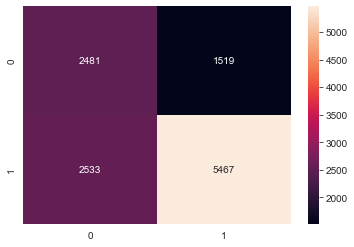

In [218]:
## Ajeitar aqui
cm_best = metrics.confusion_matrix(y_test,y_pred1)
sns.heatmap(cm_best, annot=True, fmt = 'd')

## Regressão Logística Desbalanceado

<AxesSubplot:>

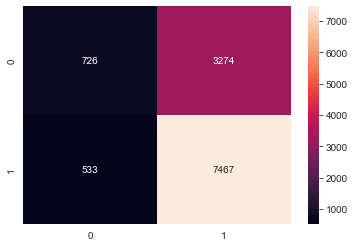

In [219]:
cm_best = metrics.confusion_matrix(y_test,y_pred5)
sns.heatmap(cm_best, annot=True, fmt = 'd')


No modelo balanceado, destaca - se que aparentemente, comparado ao modelo desbalanceado, principalmente a influência do balanceamento fez com que aumentasse os acertos nos verdadeiros negativos e diminuição dos falso positivos, contudo também houve um aumento dos falsos negativos. Assim, podemos perceber que ao utilizar esse novo cálculo de média, deixa o modelo menos descompensado ou tendente a uma classe, deixando assim os valores mais justos em relação às classes.

Já no desbalanceado, destaca-se que

## Aprendizado Não Supervisionado 

## Latent Dirichlet Allocation (LDA) Utilizando a Coluna 'comment' Pré-Processada

A lda provém da modelagem de tópicos, que é semelhante a dividir locadora de filmes com base no conteúdo de cada filme, porque se refere ao processo de descoberta de temas em um corpus de texto e anotação dos documentos com base nos tópicos identificados.

Ou seja, é uma técnica não supervisionada de aprendizado, que como a clusterização, define grupos, que nesta realidade, em que os textos são atribuídos.

Quando se precisa segmentar, entender e resumir uma grande coleção de documentos, a modelagem de tópicos pode ser útil.

LDA é um modelo probabilístico generativo no qual cada documento é assumido como sendo composto por uma proporção diferente de tópicos.

##### Logo, como funciona a utilização do método de Latent Dirichlet Allocation? Segue abaixo uma explanação:

1) Para cada documento, inicialize aleatoriamente cada palavra para um tópico entre os K tópicos onde K é o número de tópicos pré-definidos.

2) Para cada documento d:

Para cada palavra w no documento, calcule:

    - P(tópico t| documento d) : Proporção de palavras no documento d que são atribuídas ao tópico t.
    - P(palavra w| tópico t) : Proporção de atribuições ao tópico t em todos os documentos de palavras que vêm de w.

3) Reatribuir o tópico T' à palavra w com probabilidade p(t'|d)*p(w|t') considerando todas as outras palavras e suas atribuições de tópicos

A última etapa é repetida várias vezes até atingirmos um estado estável em que as atribuições dos tópicos não mudam mais.

##### Um exemplo prático, seria:

Digamos que temos os 4 documentos a seguir como corpus e desejamos realizar a modelagem de tópicos nesses documentos.

Documento 1: Assistimos a muitos vídeos no YouTube.

Documento 2: Os vídeos do YouTube são muito informativos.

Documento 3: Ler um blog técnico me faz entender as coisas facilmente.

Documento 4: Prefiro blogs a vídeos do YouTube.

A modelagem LDA nos ajuda a descobrir tópicos no corpus acima e atribuir combinações de tópicos para cada um dos documentos. Como exemplo, o modelo pode produzir algo como dado abaixo:

Tópico 1: 40% vídeos, 60% YouTube

Tópico 2: 95% blogs, 5% YouTube

Os documentos 1 e 2 pertenceriam então 100% ao Tópico 1. O Documento 3 pertenceria 100% ao Tópico 2. O Documento 4 pertenceria 80% ao Tópico 2 e 20% ao Tópico 1.

##### Ressalta-se que para a explanação sobre o assunto, tomei como base o conteúdo disponibilizado neste link: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/)

In [220]:
X_tfidf = tfidf.fit_transform(X['clean_comment'])

### Aplicando LDA no Texto 
Após vetorizar a coluna através do TF-IDF, aplicamos o método LDA do sklearn e e definimos os parâmetros do modelo LDA, conforme mostrado abaixo, incluem o número de tópicos (n_components), o método de aprendizado (learning_method), que é a maneira como o algoritmo atualiza as atribuições dos tópicos aos documentos (o método escolhido foi o 'online' por lidar melhor com grande quantidade de dados), o número máximo de iterações a serem realizadas (max_iter) e o estado aleatório (random_state). 


In [221]:
lda_model=LatentDirichletAllocation(n_components=3,
learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(X_tfidf)

### Apresentando Proporção dos Tópicos
Através de um laço, é possível verificar a proporção de cada um dos tópicos que foram atribuídos aos 4 primeiros documentos.

In [222]:
i = 0

for i in range(2,5):
    print(f'\nDocumento {i}')
    for j,topic in enumerate(lda_top[i]):
        print("Tópico ",j,": ",round(topic*100,2),"%")


Documento 2
Tópico  0 :  68.06 %
Tópico  1 :  20.0 %
Tópico  2 :  11.94 %

Documento 3
Tópico  0 :  9.15 %
Tópico  1 :  77.51 %
Tópico  2 :  13.35 %

Documento 4
Tópico  0 :  21.01 %
Tópico  1 :  23.86 %
Tópico  2 :  55.13 %


### Apresentando os tópicos
Apresentando os tópicos para que se auxilie na análise dos resultados.

In [223]:
vocab = tfidf.get_feature_names()
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:12]
    print("\nTópico "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")


Tópico 0: 
time yes know see lol would thats one mean cant much people 
Tópico 1: 
like look really got fuck say love that this make yeah need 
Tópico 2: 
think thanks you good back like though something get pretty point one 

### Análise dos Resultados
Primeiro analisando, as palavras em cada um dos três tópicos, podemos perceber que:
* As palavras do Tópico 0 trazem um contexto de comentários mais animados e com demonstração de sentimentos, como a utilização da palavra 'love'. 
* As palavras do Tópico 1 trazem um contexto de comentários com tendências de probabilismo e achismo como ao utilizar as palavras 'probably', 'look', 'think' e entre outras.
* As palavras do Tópico 2 trazem um contexto de comentários com um teor mais informal com a utilização de palavras até de baixo calão no inglês, como o 'fuck'.

Já uma interpretação geral sobre os documentos, podemos perceber que:
* O Documento 2 tem o maior peso de pertencimento ao Tópico 0, com 76.47 % de pertencimento a este tópico.
* O Documento 3 tem o maior peso de pertencimento ao Tópico 1, com 81.78 % de pertencimento a este tópico.
* O Documento 4 tem o maior peso de pertencimento ao Tópico 2, com 73.4 % de pertencimento a este tópico.

## Interpretabilidade de Predições

In [224]:
from sklearn.inspection import PartialDependenceDisplay
clf = MultinomialNB(alpha=0.5).fit(X_train_tfidf,y_train_bal.ravel())

ValueError: Found input variables with inconsistent numbers of samples: [48000, 64000]

In [ ]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from lime import lime_text

model1 = LogisticRegression(C=0.1, max_iter=300, solver='newton-cg', tol=0.001)
model1.fit(X_train_bag,y_train_bal)
pred = model1.predict(X_test_bag)
c = make_pipeline(bagwords, model1)
X_test_bag

In [ ]:
'''class_names=list(y)
explainer = LimeTextExplainer(class_names=class_names)
idx = 10
exp = explainer.explain_instance(X_test_bag[idx], 
                                 c.predict_proba, 
                                 num_features=1, 
                                 labels=[0,1])
print('Document id: %d' % idx)
print('Predicted class =', class_names[model1.predict(X_test_bag[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])'''